In [52]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import logsumexp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import geometry
import itertools
from collections import defaultdict
import collections
import target
import controler
import utils
from functools import reduce
import linear_regression
from multiprocessing import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import feedexp3
import geometry_v2

def evaluate_parallel(nbCores, n_folds, horizon, alg, game):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon)
    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''
  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class Evaluation:

    def __init__(self, horizon ):

        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution
    
    def get_outcomes(self, game, job_id):
        np.random.seed(job_id)
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, jobid):

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]
            feedback =  self.get_feedback(game, action, outcome )

            alg.update(game,  action, feedback)
            # print('outcome', outcome, 'action',action, 'eta', alg.eta, 'gamma', alg.gamma, 'pbt',alg.pbt, 'pbt_hat', alg.pbt_hat)

            # policy suffers loss and regret
            # cumAllLosses += game.LossMatrix[...,outcome]
            # cumSufferedLoss += game.LossMatrix[action,outcome]
            # cumRegret[t] = cumSufferedLoss - min(cumAllLosses)
            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        return action_counter

def eval_cpbvanilla_parallel(task, nbCores, n_folds, horizon, alpha):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    return np.asarray(  pool.map( partial( task.cpb_vanilla_v2 ,alpha ), range(n_folds) ) ) 

def runif_in_simplex(n):
  ''' Return uniformly random vector in the n-simplex '''

  k = np.random.exponential(scale=1.0, size=n)
  return k / sum(k)

class SyntheticCase:

    def __init__(self, LossMatrix, FeedbackMatrix, horizon ):
 
        self.LossMatrix = LossMatrix 
        self.FeedbackMatrix = FeedbackMatrix 
        
        self.outcome_dist = {'spam':0.05,'ham':0.95}
        self.i_star = self.optimal_action( )
        
        self.horizon = horizon
        self.n_actions = len(self.LossMatrix)
        self.n_outcomes = len(self.LossMatrix[0])

    def optimal_action(self, ):
        deltas = []
        for i in range(len(self.LossMatrix)):
            deltas.append( self.LossMatrix[i,...].T @ list( self.outcome_dist.values() ) )
        return np.argmin(deltas)

    def delta(self,action):
        return ( self.LossMatrix[action,...] - LossMatrix[self.i_star,...] ).T @ list( self.outcome_dist.values() ) 

    def set_outcomes(self, job_id):
        np.random.seed(job_id)
        #self.means = runif_in_simplex( len( LossMatrix[0] ) )
        self.outcomes = np.random.choice( self.n_outcomes , p= list( self.outcome_dist.values() ), size= self.horizon) 

    def get_feedback(self, FeedbackMatrix, action, outcome):
        return FeedbackMatrix[ action ][ outcome ] 

    def W(self, mathcal_N, N_bar, observer_vector ):
        N = len(N_bar)
        W = np.zeros( N )
        for pair in mathcal_N:
            for k in range(N):
                value = np.fabs( observer_vector[ pair[0] ][ pair[1] ][k] ).max()
                #print(value)
                W[k] = max( W[k], value  )
        return W

    def cpb_vanilla_v2(self, alpha, job_id):

        cumRegret = np.zeros( self.horizon )
        cumSufferedLoss = 0
        cumAllLosses = np.zeros( self.n_actions )
        regret = []
        action_counter = np.zeros( (self.n_actions, self.horizon) )

        self.set_outcomes(job_id)

        N_bar = set(range(self.n_actions))
        M_bar = set(range(self.n_outcomes))
        e = np.eye(self.n_outcomes)

        n = np.zeros(self.n_actions)
        nu = [  np.zeros( len( set(i) ) ) for i in self.FeedbackMatrix ] 
        N, M = LossMatrix.shape
        
        mathcal_P = [  i for i in N_bar if geometry.isParetoOptimal(i, LossMatrix)  ]#geometry.get_P_t([], LossMatrix) #geometry.getParetoOptimalActions(LossMatrix, []) #get_P_t(half_space, self.LossMatrix, mathcal_P, mathcal_N) #[ a for a in N_bar if geometry.isParetoOptimal(a, self.LossMatrix )] # set of pareto optimal actions
        mathcal_N = [ [i,j] for i in N_bar for j in N_bar if geometry.areNeighbours(i,j,LossMatrix) ]#geometry.get_N_t([], self.LossMatrix) #geometry.getNeighbors(LossMatrix, []) #[ pair for pair in list( itertools.combinations(N_bar, 2) ) if geometry.areNeighbours(pair[0], pair[1], self.LossMatrix ) ] #set of unordered neighboring actions
        print('mathcal_P',mathcal_P)
        print('mathcal_N',mathcal_N)
        mathcal_N_plus = collections.defaultdict(dict)
        for pair in mathcal_N:
            mathcal_N_plus[ pair[0] ][ pair[1] ] = geometry.get_neighborhood_action_set(pair, N_bar, self.LossMatrix )
        print('neighborhood action set:', mathcal_N_plus)

        S_vectors = [ np.array([ 1,1 ]), np.array([ [0,1],[1,0]] ) ] #geometry.global_signal(FeedbackMatrix) #geometry.get_signal_matrices(self.FeedbackMatrix)
        print('S vectors', S_vectors)

        # print('mathcalP', mathcal_P)
        # print('mathcalN', mathcal_N)
        # observer_set = collections.defaultdict(dict)
        # for pair in mathcal_N : 
        #     if geometry.ObservablePair(pair[0], pair[1], self.LossMatrix, [geometry.signal_vecs(i, self.FeedbackMatrix) for i in geometry.Neighbourhood(pair[0], pair[1], self.LossMatrix )]):
        #         observer_set [ pair[0] ][ pair[1] ] =   mathcal_N_plus[ pair[0] ][ pair[1] ] 
        #     else:
        #         observer_set [ pair[0] ][ pair[1] ] = None
        #         print('Observer set -- not implemented')

        observer_vector = collections.defaultdict(dict)
        for pair in mathcal_N :
            # print('pair', pair)
            observer_vector[ pair[0] ][ pair[1] ] = geometry.get_observer_vector_v2(pair, LossMatrix, FeedbackMatrix ) #geometry_v2.get_observer_vector(pair ,self.LossMatrix ,self.FeedbackMatrix, S_vectors ) 
        print( 'Observer vectors', observer_vector )


        W = self.W( mathcal_N, N_bar, observer_vector )
        print('W', W)

        # print('mathcal P', mathcal_P)
        # print('mathcal N', mathcal_N)

        for t in range(self.n_actions):

            action  = t
            outcome = self.outcomes[t]
            Y = geometry.signal_vecs(action, self.FeedbackMatrix) @ e[outcome]
            n[action] += 1
            nu[action] += Y
            regret.append(action)

            # policy suffers loss and regret
            cumAllLosses += self.LossMatrix[...,outcome]
            cumSufferedLoss += self.LossMatrix[action,outcome]
            cumRegret[t] = cumSufferedLoss - min(cumAllLosses)

            for i in range(self.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t] +1
                else:
                    action_counter[i][t] = action_counter[i][t]


                    
        for t in range(self.n_actions, self.horizon):

            mathcal_P_t = mathcal_P
            mathcal_N_t = mathcal_N

            outcome = self.outcomes[t]
            half_space = []

            for pair in mathcal_N:
                # print( 'inside', [  observer_vector[ pair[0] ][ pair[1] ][k].T * v[k]/n[k]   for k in mathcal_N_plus ] )
                d_ij, c = 0, 0 
                for k in mathcal_N_plus[pair[0]][pair[1]]:
                    # print('observer vector',observer_vector[ pair[0] ][ pair[1] ][k],'nu',nu[k] )
                    d_ij += observer_vector[ pair[0] ][ pair[1] ][k].T @ nu[k]  / n[k] 
                    c += np.fabs(  observer_vector[ pair[0] ][ pair[1] ][k] ).max()  * np.sqrt(alpha * np.log(t) / n[k] )  
                print('pair',pair,'d_ij',d_ij, 'c', c)
                        
                if abs( d_ij ) >= c:
                    half_space.append(  ( pair, np.sign(d_ij) ) )
                else:
                    half_space.append(  ( pair, 0 ) )

            print('halfspace',half_space)

            # print('halfspace', half_space)

            #print('P before:',mathcal_P)
            mathcal_P_t = geometry.get_P_t(half_space, LossMatrix)#geometry.getParetoOptimalActions(LossMatrix, half_space) #get_P_t(half_space, self.LossMatrix, mathcal_P, mathcal_N)
            print('mathcal_P_t',mathcal_P)

            #print('N before:',mathcal_N)
            mathcal_N_t = geometry.get_N_t(half_space, self.LossMatrix) #getNeighbors(LossMatrix, half_space) #get_N_t(half_space, self.LossMatrix, mathcal_P, mathcal_N)
            print('mathcal_N_t:',mathcal_N_t)
            #print()

            
            #print('mathcal_n_plus', mathcal_N_plus)
            Q = reduce( np.union1d, [ mathcal_N_plus[ pair[0] ][ pair[1] ]  for pair in mathcal_N_t ]  )
            # print('Q', Q)
            values = [ W[k]**2/n[k] for k in Q ]
            
            action = np.argmax(values)
            print('action', action, 'outcome', outcome, 'S', S_vectors[action],'e', e[outcome] )
            Y = S_vectors[action] @ e[outcome]
            n[action] += 1
            nu[action] += Y

            print('values', values, 'action', action, 'n', n, 'nu', nu)

            # policy suffers loss and regret
            # cumAllLosses += self.LossMatrix[...,outcome]
            # cumSufferedLoss += self.LossMatrix[action,outcome]
            regret.append(  self.delta(action)  ) #cumSufferedLoss - min(cumAllLosses)

            for i in range(self.n_actions):
                if i == action:
                    action_counter[action][t] = action_counter[action][t] +1
                else:
                    action_counter[action][t] = action_counter[action][t]

        return action_counter

In [91]:




LossMatrix = np.array( [ [1, 0], [0, 1] ] )
i = optimal_action(LossMatrix, )


0

In [31]:
FeedbackMatrix =  np.array([ [1, 1],[1, 0] ])
e = np.eye(2)
S = geometry.global_signal(FeedbackMatrix) 
S2 = geometry_v2.get_signal_matrices(FeedbackMatrix)
S[1] @ e[1]

array([1., 0.])

mathcal_P [0, 1]
mathcal_N [[0, 0], [0, 1], [1, 0], [1, 1]]
neighborhood action set: defaultdict(<class 'dict'>, {0: {0: [0], 1: [0, 1]}, 1: {0: [0, 1], 1: [1]}})
S vectors [array([1, 1]), array([[0, 1],
       [1, 0]])]
Observer vectors defaultdict(<class 'dict'>, {0: {0: [array([0]), array([0, 0])], 1: [array([0.33333333]), array([-1.        ,  0.33333333])]}, 1: {0: [array([0.33333333]), array([0.33333333, 1.        ])], 1: [array([0]), array([0, 0])]}})
W [0.33333333 1.        ]
pair [0, 0] d_ij 0.0 c 0.0
pair [0, 1] d_ij -0.6666666666666666 c 1.3595559868917455
pair [1, 0] d_ij 0.6666666666666666 c 1.3595559868917455
pair [1, 1] d_ij 0.0 c 0.0
halfspace [([0, 0], 0.0), ([0, 1], 0), ([1, 0], 0), ([1, 1], 0.0)]
mathcal_P_t [0, 1]
mathcal_N_t: [[0, 0], [0, 1], [1, 0], [1, 1]]
action 1 outcome 1 S [[0 1]
 [1 0]] e [0. 1.]
values [0.1111111111111111, 1.0] action 1 n [1. 2.] nu [array([1.]), array([2., 0.])]
pair [0, 0] d_ij 0.0 c 0.0
pair [0, 1] d_ij -0.6666666666666666 c 1.33562624406

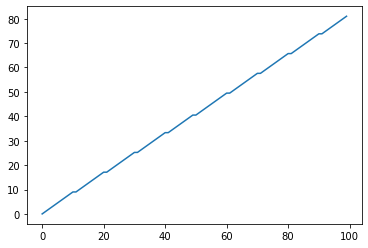

In [144]:
n_cores = 16
horizon = 100
n_folds = 25

LossMatrix = np.array( [ [1, 0], [0, 1] ] )
FeedbackMatrix =  np.array([ [1, 1],[1, 0] ])

task = SyntheticCase(LossMatrix, FeedbackMatrix, horizon) 
result = task.cpb_vanilla_v2( 1.5, 5)  
regret = np.cumsum( np.array( [ task.delta(i) for i in range(2) ] ).T @ result )
plt.plot(regret)

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Piccolboni' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Piccolboni', color = 'green' )

# result =  eval_feedexp_parallel(task, n_cores, n_folds, horizon, True, 'Bianchi' ) 
# plt.plot(  np.mean( result , 0 ) , label = 'Bianchi', color = 'orange' )

# plt.legend()

In [53]:
n_cores = 16
n_folds = 100
horizon = 500

outcome_distribution =  {'spam':0.05,'ham':0.95}

nbCores: 16 nbFolds: 100 Horizon: 500
nbCores: 16 nbFolds: 100 Horizon: 500


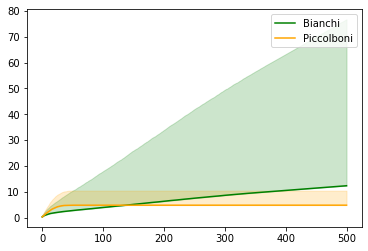

In [105]:
game = games.apple_tasting(False, outcome_distribution)

alg = feedexp3.FeedExp3(  game, horizon, 'Bianchi',)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result1,0) 
std1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result1,0) 
plt.plot(   regret1 , label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon) ,  regret1    , regret1 + std1 , color = 'green' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Piccolboni', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

plt.legend()


nbCores: 16 nbFolds: 100 Horizon: 500
nbCores: 16 nbFolds: 100 Horizon: 500


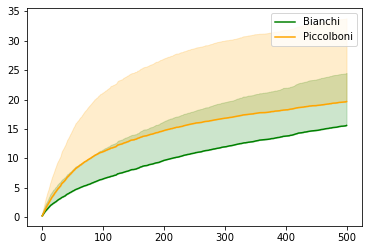

In [106]:
game = games.bandit(False,outcome_distribution)


alg = feedexp3.FeedExp3(  game, horizon, 'Bianchi',)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result1,0) 
std1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result1,0) 
plt.plot(   regret1 , label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon) ,  regret1    , regret1 + std1 , color = 'green' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Piccolboni', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

plt.legend()


nbCores: 16 nbFolds: 100 Horizon: 500
nbCores: 16 nbFolds: 100 Horizon: 500


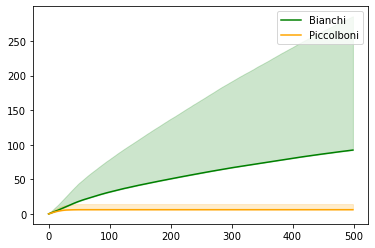

In [107]:
game = games.label_efficient(outcome_distribution)

alg = feedexp3.FeedExp3(  game, horizon, 'Bianchi',)
result1 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result1,0) 
std1 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result1,0) 
plt.plot(   regret1 , label = 'Bianchi', color = 'green' )
plt.fill_between( range(horizon) ,  regret1    , regret1 + std1 , color = 'green' , alpha = 0.2)

alg = feedexp3.FeedExp3(  game, horizon, 'Piccolboni',)
result2 = evaluate_parallel(n_cores, n_folds, horizon, alg, game)
regret2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result2,0) 
std2 = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.std(result2,0) 
plt.plot(   regret2  , label = 'Piccolboni', color = 'orange' )
plt.fill_between( range(horizon) ,  regret2    , regret2 + std2 , color = 'orange' , alpha = 0.2)

plt.legend()


In [ ]:
import ppl
M = 2
p = [ppl.Variable(j) for j in range(M)]
    
# declare polytope constraints
cs = ppl.Constraint_System()
    
# probabilies constraints on p
cs.insert( sum( p[j] for j in range(M)) == 1 )
for j in range(M):
    cs.insert(p[j] >= 0)

cs.insert(p[0] - p[1] <= 0)   
cs.insert(p[1] - p[0] <= 0)   

poly = ppl.C_Polyhedron(cs)

poly.minimized_generators()